## Nonlinear MPC Stopping at Stop Sign

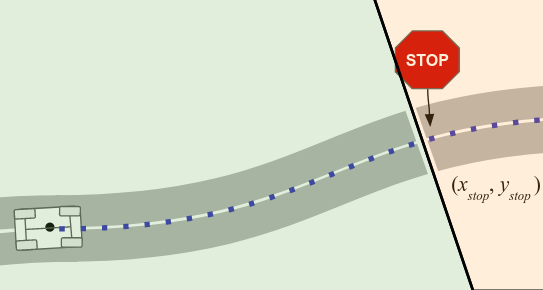

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Set up the road data

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from trajectory_planner import TrajectoryPlanner
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

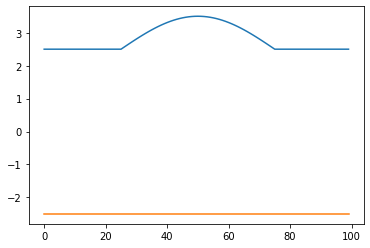

In [2]:
# Generates a straight test_road
test_road = np.ones((100,2))
for i in range(100):
    test_road[i,0] = i

left_width = 2.5*np.ones(np.size(test_road)//2)
right_width = 2.5*np.ones(np.size(test_road)//2)
right_width[25:75] += np.sin(np.arange(50)*np.pi/50) # add a "turnout" to demonstrate this feature
plt.plot(np.arange(100), right_width)
plt.plot(np.arange(100), -left_width)

## Initialize the car and road model

In [3]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
params = {"step":0.075,
          "N":30,
          "n":4, # 4 states
          "m":2, # 2 control inputs
         }
planner = TrajectoryPlanner(**params)

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        left_width  = left_width,
                        right_width = right_width,
                        P           = np.size(left_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

### Set up the desired_speed function

In [21]:
# stop sign test

# Speed to start at
DESIRED_SPEED = 4.0
# x-y position of stop sign
stop_sign = (15.0,1.0)

# Computes the distance from a provided xy point to the stop sign line
def dist_to_stop_line(xy):
    x0, y0 = stop_sign
    x,y = xy
    dist = np.sqrt((y-y0)**2 + (x-x0)**2)*np.cos(np.arctan2(y0-y, x0-x))
    return dist

def desired_speed(x, y, k):
    xy = np.array([x,y])
    # 1: Find closest point to xy on road centerline
    dist = dist_to_stop_line(xy)
    # 2: Linear relationship between distance and speed
    if np.abs(dist) > 10:
        return DESIRED_SPEED
    elif dist < 0.05:
        return np.max([0, np.abs(DESIRED_SPEED*(dist-0.1)/10.0)])
    else:
        return np.max([0, np.abs(DESIRED_SPEED*(dist)/10.0)])

x = np.arange(0, 30)
y = np.ones(30)
for xi, yi in zip(x, y):
    print(desired_speed(0, xi, yi))

4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


### Set up the driveable_corridor function

In [22]:
def driveable_corridor(x, y, s):
    state = roadrunner.save_state()
    step = roadrunner.advance_xy(np.array([x,y]))
    xy, psi, dl, dr = roadrunner.evaluate(s, full_data=True)
    xy = np.reshape(xy, 2)
    roadrunner.reset(**state)
    return xy[0], xy[1], psi, dl, dr

### Set up the constraint_generator
It returns a function that is <= 0 when the vehicle is before the stop sign

In [46]:
def constraint_generator(x, y, v, psi, k):
    def g(zk, index):
        x0, y0 = stop_sign
        
        return -((zk[1]-y0)**2 + (zk[0]-x0)**2)*np.cos(np.arctan2(y0-zk[1], x0-zk[0]))
    return g

x = casadi.MX.sym("x", 4)
print(x)
g = constraint_generator(np.ones(4,), 0)

g(x, 0)

x


MX((-((sq((x[1]-1))+sq((x[0]-15)))*cos(atan2((1-x[1]),(15-x[0]))))))

In [42]:
xy, angle, dl, dr = roadrunner.evaluate(full_data=True)
ic = np.array([xy[0,0], xy[0,1], desired_speed(xy[0,0], xy[0,1], 0), angle])
print("Initial conditions: x, y, v, phi =", ic)

Initial conditions: x, y, v, phi = [14.40605076  1.          0.2375797   0.        ]


## Run the MPC algorithm

### Cost weights

In [25]:
weights = {
       "accuracy":10.0,
           "jerk":1.0,
"steering change":10.0,
       "acceleration":0.0,
}
# use acceleration weight for stopping scenario


# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 100

## Initialize the trajectory planner

In [26]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(2)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], desired_speed(0, xy[0], xy[1]), roadrunner.get_angle()]

z_est, u_est = planner.generate_first_estimate(ic, driveable_corridor, desired_speed, constraint_generator)
planner.mpcprob.model.state_estimate =z_est
planner.mpcprob.model.control_estimate =u_est

planner.setup_to_save_data(n_runs)

planner.z0 = ic
estimated_path, _, _ = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
planner.initialize_first_mpc_problem(estimated_path)

<IPython.core.display.Javascript object>


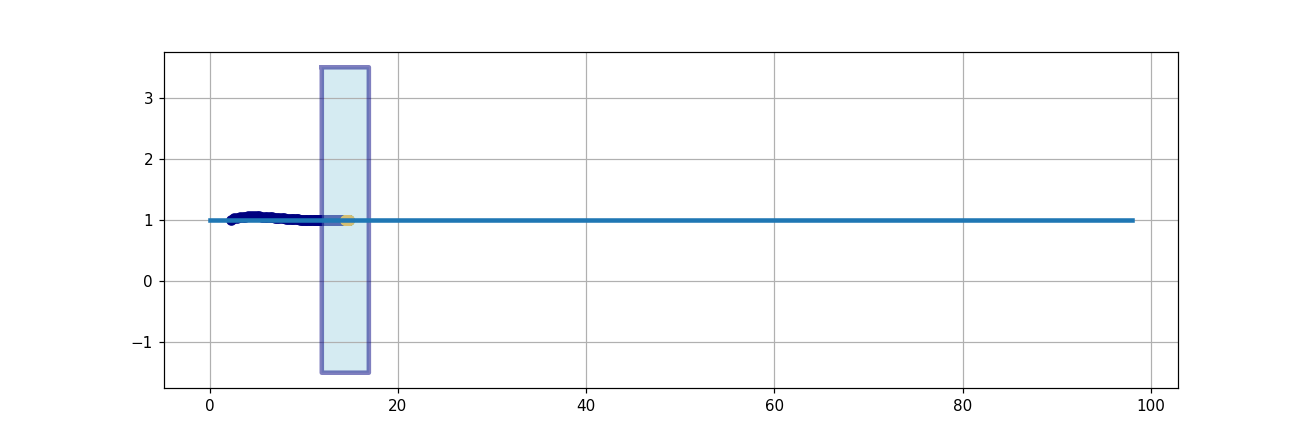

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:      120
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      120

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [27]:
%matplotlib notebook

# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+params["N"],4,2))

fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(planner.x_true[0], planner.x_true[1], color="red")[0]
#ax_traj.quiver(x_true[0,0], x_true[1,0], x_true[2,0]*np.cos(x_true[3,0]), x_true[2,0]*np.sin(x_true[3,0]), color="blue")
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0
# test: hack? TODO fix, July 20th, 2021
#mpcprob.weights["acceleration"] = 100.
#acc = mpcprob.weights["accuracy"]

try:
    while k < n_runs:

        
        estimated_path, left_widths, right_widths = planner.generate_path_estimate(driveable_corridor, desired_speed, constraint_generator)
        # Solve the MPC problem
        problem = planner.build_mpc_problem(estimated_path, left_widths, right_widths, weights, constraint_generator(planner.z0, k))
        xk_opt, uk_opt, sol = planner.solve_mpc_problem(problem)
        
        # for plotting
        planner.centers[:,k+1] = planner.mpcprob.x_center_plot[:,1]


        # Save the next state x_k+1 and control u_k+1
        for i in range(params["n"]):
            planner.x_plan[i,k+1] = xk_opt[i][1]
        for i in range(params["m"]):
            planner.u_plan[i,k] = uk_opt[i][1]
        _,p = planner.mpcprob.bound_x(estimated_path[0,0], estimated_path[1,0], estimated_path[3,0], left_widths[0], right_widths[0])
        planner.polygon_boundaries[k,:,:] = p
        
        planner.x_true[:,k+1] = planner.apply_control(planner.u_plan[:,k])
        planner.z0 = planner.x_true[:,k+1]
        
        planner.initialize_nth_mpc_problem(xk_opt, uk_opt)
    
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(planner.x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())

        # for plotting
        # Plot arrows and x-y states
        ax_traj.clear()
        ax_traj.scatter(planner.x_true[0,:k], planner.x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        # Plot the polygon fill
        ax_traj.fill(planner.polygon_boundaries[k,:,0], planner.polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([planner.polygon_boundaries[k,:,0],planner.polygon_boundaries[k,0:1,0]]),
                np.concatenate([planner.polygon_boundaries[k,:,1],planner.polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)
        
        ax_traj.scatter(estimated_path[0,:], estimated_path[1,:], color="green")
        
        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")
       # ax_traj.scatter(stop_sign[0], stop_sign[1], color="red")

        roadrunner.plot(ax=ax_traj, n_points=50)
        
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1
        '''
        # stop sign test??
        
        idx = xk_opt[0].size-1
        xy_last = np.array([xk_opt[0][idx], xk_opt[1][idx]])
        dist = dist_to_stop_line(xy_last)
        print("\n\ndist", dist)
        mpcprob.indices_to_stop = None
        while dist <= stop_dist and idx >= 0 and mpcprob.indices_to_start is not None:
            mpcprob.indices_to_stop = idx
            
            print("\n\nStopping index", idx)
            idx -= 1
            xy_last = np.array([xk_opt[0][idx], xk_opt[1][idx]]) 
            dist = dist_to_stop_line(xy_last)
        
        # restart test??
        if mpcprob.indices_to_stop == 0: # car is at a stop
            # now begin moving forward
            mpcprob.indices_to_stop = None
        '''
except OutOfRoadPointsException as e:
    print(e)
    planner.x_plan = planner.x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
    planner.u_plan = planner.u_plan[:,:k]  
    planner.x_true = planner.x_true[:,k+1]
    planner.centers = planner.centers[:,k+1]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
finally:
    fig_traj.canvas.draw()


In [28]:
# turn interactive off
plt.ioff()
planner.x_plan = planner.x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
planner.u_plan = planner.u_plan[:,:k]  
planner.x_true = planner.x_true[:,k+1]
planner.centers = planner.centers[:,k+1]


## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


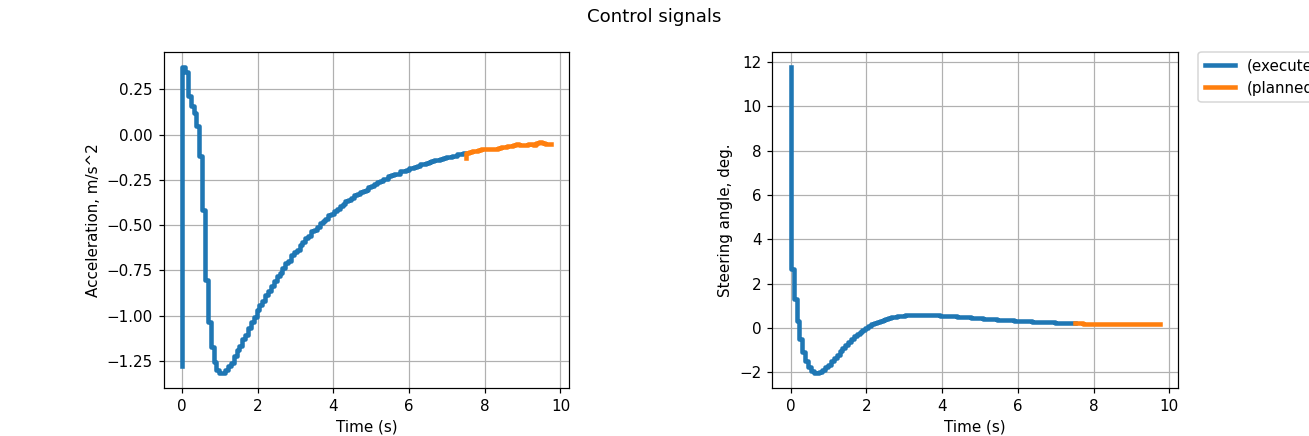

In [29]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(planner.u_plan, planner.mpcprob.u_opt, params["step"], params["N"])

plt.show()